In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8')  # make plots a bit nicer by default

## To do / Questions

1. Finish rewriting old code
    * $Q$, multi-$w$
    * $UU^\top$, training loop
    * $UU^\top$, single $w$
    * $UU^\top$, multi-$w$

2. Check that each of the above is learning properly
    * Performs better than one step of GD
        * on new data with the same $w_\star$
        * on new data with a different $w_\star$??
    * How consistent are learned matrices over multiple runs w/ same init?
        * if not consistent, what properties do they share?

3. What patterns are visible in learned $Q$?
    * Eigenvalues, vectors.
    * Low-rank $\Sigma_w$: do you capture this subspace?
    * Patterns in imshow

4. Update potential based on whole batch rather than a single datapoint, for easier interp?

5. Optimization-style objective, rather than crossval

# Generating data

In [2]:
def generate_linear_data(d_feature: int, n_samples: int, w_cov: np.ndarray = None, noise_scale: float = 0.0) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Generates data y = Xw + e where X is (n_samples, d_feature) and w is (d_feature, 1).

    Args:
        d_feature: Dimension of feature space.
        n_samples: Number of samples to generate.
        w_cov: Covariance matrix for generating w. If None, uses identity matrix.
        noise_scale: Standard deviation of Gaussian noise.

    Returns:
        X: Feature matrix of shape (n_samples, d_feature).
        y: Target vector of shape (n_samples,).
        w: True weight vector of shape (d_feature,).
    """
    if w_cov is None:
        w_cov = np.eye(d_feature)
    
    w = np.random.multivariate_normal(mean=np.zeros(d_feature), cov=w_cov)
    X = np.random.randn(n_samples, d_feature)
    y = X @ w + np.random.normal(scale=noise_scale, size=(n_samples,))
    
    return X, y.ravel(), w


def generate_mixed_linear_data(d_feature: int, n_samples_per_w: int, n_ws: int, w_cov: np.ndarray = None, noise_scale: float = 0.0) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Generates data y = Xw + e for multiple w vectors.

    Args:
        d_feature: Dimension of feature space.
        n_samples_per_w: Number of samples to generate for each w.
        n_ws: Number of different w vectors to use.
        w_cov: Covariance matrix for generating w. If None, uses identity matrix.
        noise_scale: Standard deviation of Gaussian noise.

    Returns:
        X: Feature matrix of shape (n_ws * n_samples_per_w, d_feature).
        y: Target vector of shape (n_ws * n_samples_per_w,).
        W: Matrix of true weight vectors of shape (n_ws, d_feature).
    """
    if w_cov is None:
        w_cov = np.eye(d_feature)
    
    W = np.random.multivariate_normal(mean=np.zeros(d_feature), cov=w_cov, size=n_ws)
    X = np.random.randn(n_ws * n_samples_per_w, d_feature)
    y = np.concatenate([X[i * n_samples_per_w : (i+1) * n_samples_per_w] @ W[i] for i in range(n_ws)])
    y += np.random.normal(scale=noise_scale, size=y.shape)
    
    return X, y, W


def generate_specified_linear_data(n_samples_per_w: int, w_stars: np.ndarray, noise_scale: float = 0.0) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Generates data y = Xw + e for specified w vectors.

    Args:
        n_samples_per_w: Number of samples to generate for each w.
        w_stars: Array of weight vectors, shape (n_ws, d_feature).
        noise_scale: Standard deviation of Gaussian noise.

    Returns:
        X: Feature matrix of shape (n_ws * n_samples_per_w, d_feature).
        y: Target vector of shape (n_ws * n_samples_per_w,).
        W: Matrix of true weight vectors of shape (n_ws, d_feature).
    """
    n_ws, d_feature = w_stars.shape
    X = np.random.randn(n_ws * n_samples_per_w, d_feature)
    y = np.concatenate([X[i*n_samples_per_w:(i+1)*n_samples_per_w] @ w_stars[i] for i in range(n_ws)])
    y += np.random.normal(scale=noise_scale, size=y.shape)
    
    return X, y, w_stars


def generate_std_basis_data(d_feature: int, n_samples: int, w: np.ndarray = None) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Generates data y = Xw where X consists of standard basis vectors.

    Args:
        d_feature: Dimension of feature space.
        n_samples: Number of samples to generate (must be <= d_feature).
        w: True weight vector. If None, randomly generated.

    Returns:
        X: Feature matrix of shape (n_samples, d_feature).
        y: Target vector of shape (n_samples,).
        w: True weight vector of shape (d_feature,).
    """
    assert n_samples <= d_feature, "n_samples must be <= d_feature for standard basis vectors"
    
    if w is None:
        w = np.random.randn(d_feature)
    
    X = np.eye(d_feature)[:n_samples]
    y = (X @ w).ravel()
    
    return X, y, w


def generate_mixed_std_basis_data(d_feature: int, n_samples_per_w: int, n_ws: int, w_cov: np.ndarray = None, noise_scale: float = 0.0) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Generates data y = Xw + e for multiple w vectors, where X consists of standard basis vectors.

    Args:
        d_feature: Dimension of feature space.
        n_samples_per_w: Number of samples to generate for each w (must be <= d_feature).
        n_ws: Number of different w vectors to use.
        w_cov: Covariance matrix for generating w. If None, uses identity matrix.
        noise_scale: Standard deviation of Gaussian noise.

    Returns:
        X: Feature matrix of shape (n_ws * n_samples_per_w, d_feature).
        y: Target vector of shape (n_ws * n_samples_per_w,).
        W: Matrix of true weight vectors of shape (n_ws, d_feature).
    """
    assert n_samples_per_w <= d_feature, "n_samples_per_w must be <= d_feature for standard basis vectors"
    
    if w_cov is None:
        w_cov = np.eye(d_feature)
    
    W = np.random.multivariate_normal(mean=np.zeros(d_feature), cov=w_cov, size=n_ws)
    X = np.tile(np.eye(d_feature)[:n_samples_per_w], (n_ws, 1))
    y = np.concatenate([W[i, :n_samples_per_w] for i in range(n_ws)])
    y += np.random.normal(scale=noise_scale, size=y.shape)
    
    return X, y, W

# $Q$ parameterization: not ensuring psd or symmetric

## Basic training loop ✅

In [3]:
def mirror_descent_step(w: np.ndarray, Q: np.ndarray, lr: float, x: np.ndarray, y: float) -> np.ndarray:
    """
    Single step of mirror descent.
    [ 7.1: this function isn't actually used right now, since the potential update computes this manually ]

    Args:
        w: Current weight vector (d_feature, 1).
        Q: Potential matrix (d_feature, d_feature).
        lr: Learning rate.
        x: Feature vector (d_feature,).
        y: Target value.

    Returns:
        Updated weight vector (d_feature,).
    """
    return w - 2 * lr * (np.inner(w, x) - y) * (Q @ x)


def crossval(w: np.ndarray, Q: np.ndarray, lr: float, X: np.ndarray, y: np.ndarray,
             ignore_diag=True) -> float:
    """
    Perform leave-one-out cross-validation.

    For each (x_i, y_i) in the dataset:
    1. "Train" a model with a single step of mirror descent on (x_i, y_i)
    2. Evaluate it on the rest of the dataset

    Tested against non-vectorized version, performs identically.

    Args:
        w: Initial weight vector (d_feature,).
        Q: Potential matrix (d_feature, d_feature).
        lr: Learning rate.
        X: Feature matrix (n_samples, d_feature).
        y: Target vector (n_samples,).

    Returns:
        Average loss over all i, j with i != j.
    """
    n, d = X.shape

    # Compute all pairwise losses in a vectorized manner
    errors = X @ w - y  # (n_samples,)
    XQX = X @ Q.T @ X.T  # (n_samples, n_samples)
    
    # Broadcasting to compute L_ij for all i, j
    L_squared = (errors - 2 * lr * errors[:, np.newaxis] * XQX)**2  # (n_samples, n_samples)
    
    # Enforcing i != j condition, if applicable
    if ignore_diag:
        np.fill_diagonal(L_squared, 0)
        denom = 2 * n * (n-1)
    else:
        denom = 2 * n**2
    
    return np.sum(L_squared) / denom  # average over all L_ij


def potential_update(w: np.ndarray, Q: np.ndarray, outer_lr: float, inner_lr: float, X: np.ndarray, y: np.ndarray,
                     ignore_diag=True) -> np.ndarray:
    """
    Update the potential matrix Q based on the derivative of the cross-validation loss.

    Args:
        w: Current weight vector (d_feature,).
        Q: Current potential matrix (d_feature, d_feature).
        outer_lr: Learning rate for updating Q.
        inner_lr: Learning rate for the inner mirror descent step (η in the formula).
        X: Feature matrix (n_samples, d_feature).
        y: Target vector (n_samples,).

    Returns:
        Updated potential matrix Q (d_feature, d_feature).
    """
    n_samples = X.shape[0]
    
    errors = X @ w - y  # (n_samples,)
    XQX = X @ Q.T @ X.T  # (n_samples, n_samples)
    L = errors - 2 * inner_lr * errors[:, np.newaxis] * XQX  # L_{ij}, (n_samples, n_samples)
    
    # Enforce i != j condition, if applicable
    if ignore_diag:
        np.fill_diagonal(L, 0)
        denom = n_samples * (n_samples - 1)
    else:
        denom = n_samples ** 2
    
    # Black magic einsum expression to combine everything
    # Breaking it down:
    #  Crossval derivative involves errors_i, L_{ij}, and x_j x_i^T.
    #  The indices of L are i,j
    #  The index of errors is i
    #  The way to do "sum over all outer products of pairs of rows" is jk,il->kl
    #   (this isn't so obvious, but see "scratch work" below to walk through.)
    update = np.einsum('ij,i,jk,il->kl', L, errors, X, X)
    update *= -2 * inner_lr / denom
    return Q - outer_lr * update

In [4]:
def potential_training_loop(d, n, inner_lr, outer_lr, w0, Q0, n_iters,
                            w_cov=None, noise_scale=0, seed=None):
    """
    Basic training loop.
    Generates linear data and runs potential_update for n_iters iterations.

    Returns crossvals, Qs, X, y, w_star.
    """
    if seed:
        np.random.seed = seed

    X, y, w_star = generate_linear_data(d, n, w_cov, noise_scale)

    crossvals = np.zeros(n_iters)
    Q = Q0.copy()
    Qs = np.zeros((n_iters, d, d))
    Qs[0] = Q.copy()
    for i in range(n_iters):
        crossvals[i] = crossval(w0, Q, inner_lr, X, y, ignore_diag=True)
        Q = potential_update(w0, Q, outer_lr, inner_lr, X, y, ignore_diag=False)
        Qs[i] = Q.copy()

    return crossvals, Qs, X, y, w_star

### Checking correctness of `crossval` and `potential_update` ✅

In [5]:
# test crossval and potential_update against unvectorized versions

def random_experiment_setup():
    d_feature = np.random.randint(5, 15)
    n_samples = np.random.randint(5, 100)
    lr = np.random.uniform(0.01, 1)
    noise_scale = np.random.uniform(0, 1)

    X, y, w_star = generate_linear_data(d_feature, n_samples, noise_scale=noise_scale)

    w = np.random.randn(d_feature)
    Q = np.random.randn(d_feature, d_feature)

    return d_feature, n_samples, lr, X, y, w_star, w, Q

n_tests = 15

# ------------------------ Testing L_ij -----------------------------
for _ in range(n_tests):
    d, n, lr, X, y, w_star, w, Q = random_experiment_setup()
    z = X @ w - y
    M = X @ Q.T @ X.T
    L = (z - 2 * lr * z[:, np.newaxis] * M)  # L[i,j] = L_{ij}

    # check that it works
    for i in range(min(d,n)):
        for j in range(min(d,n)):
            manual_calc = z[j] - 2 * lr * z[i] * X[j].T @ Q @ X[i]
            assert np.isclose(L[i,j], manual_calc), f"{i,j} {L[i,j], manual_calc}"
print("L_ij passed test.")


# ------------------------ Testing crossval -----------------------------
def crossval_nonvec(w, Q, lr, xs, ys):
    """
    For each (x_i, y_i) in zip(xs, ys):
    1. "Train" a model with a single step of mirror descent on (x_i, y_i)
    2. Evaluate it on the rest of the dataset
    Return the average loss over all i, j with i != j.
    """
    k = len(xs)
    def L_ij(w, Q, xi, xj, yi, yj):
        return ( w.T @ xj - 2 * lr * (w.T @ xi - yi) * (xj.T @ Q @ xi) - yj )**2
    value = 0
    for i, (xi, yi) in enumerate(zip(xs, ys)):
        for j, (xj, yj) in enumerate(zip(xs, ys)):
            if i == j:
                continue
            value += L_ij(w, Q, xi, xj, yi, yj).item()
    return value / (2 * k * (k-1))

for _ in range(n_tests):
    # all parameters are randomized over a bunch of runs
    d_feature, n_samples, lr, X, y, w_star, w, Q = random_experiment_setup()

    # Prepare inputs for crossval_nonvec
    xs = [X[i, :].reshape(-1, 1) for i in range(n_samples)]  # list of (d_feature, 1) arrays
    ys = y.tolist()  # list of floats

    result_nonvec = crossval_nonvec(w[:, np.newaxis], Q, lr, xs, ys)
    result_vec = crossval(w, Q, lr, X, y)

    assert np.isclose(result_nonvec, result_vec) 
print("crossval passed test.")


# ------------------------ Testing potential_update -----------------------------
def potential_update_nonvec(w, Q, outer_lr, inner_lr, xs, ys):
    """
    Derivative of the cross-validation loss (as implemented in `crossval` above)
    with respect to the matrix Q.

    Returns the updated matrix.
    """
    k = len(xs)
    def cv_derivative(w, Q, lr, xi, xj, yi, yj):
        err = (w.T @ xi - yi).item()
        #return (w.T @ xj - 2 * lr * err * (xi.T @ Q @ xj) - yj).item() * err * np.outer(xi, xj)
        return (w.T @ xj - 2 * lr * err * (xj.T @ Q @ xi) - yj).item() * err * (xj @ xi.T)
    
    update = 0
    for i, (xi, yi) in enumerate(zip(xs, ys)):
        for j, (xj, yj) in enumerate(zip(xs, ys)):
            if i != j:
                update += cv_derivative(w, Q, inner_lr, xi, xj, yi, yj)
    update = - 2 * inner_lr * update / (k * (k - 1))
    return Q - outer_lr * update

for _ in range(n_tests):
    d_feature, n_samples, inner_lr, X, y, w_star, w, Q = random_experiment_setup()
    outer_lr = np.random.uniform(0.01, 1)

    xs = [X[i, :].reshape(-1, 1) for i in range(n_samples)]  # list of (d_feature, 1) arrays
    ys = y.tolist()  # list of floats

    result_nonvec = potential_update_nonvec(w, Q, outer_lr, inner_lr, xs, ys)
    result_vec = potential_update(w, Q, outer_lr, inner_lr, X, y)
    assert np.allclose(result_nonvec, result_vec) 
print("potential_update passed test.")
    


L_ij passed test.
crossval passed test.
potential_update passed test.


In [6]:
# Scratch work: how do you vectorize "sum of outer products of rows of X"

# i.e. sum_{i,j} np.outer(x_i, x_j)
d, n = 5, 10
X = np.random.randn(n,d)

# sum of outer products of rows, written as a loop
sopr = np.zeros((d,d))
for i in range(n):
    for j in range(n):
        sopr += np.outer(X[j], X[i])

# turn the loop into a nested list comprehension: (n,d) -> (n, n, d, d), and then sum over first two dims
expand = np.array( [[ np.outer(X[i], X[j]) for j in range(n)] for i in range(n)] )
sopr2 = expand.sum((0,1))
assert np.allclose(sopr, sopr2)

# turn into einsum: same expand step first, then sum over first two indices
einsum_expand = np.einsum('ik,jl->ijkl', X, X)
sopr3 = np.einsum('ik,jl->ijkl', X, X).sum((0,1))
assert np.allclose(einsum_expand, expand)
assert np.allclose(sopr, sopr3)

# finally, turn into an even simpler einsum
sopr4 = np.einsum('ik,jl->kl', X, X)
assert np.allclose(sopr, sopr4)

### Known example: noiseless case, standard basis data ✅

In [7]:
def optimal_non_pd_potential_std_basis(w0: np.ndarray, w_star: np.ndarray, lr: float = 0.5) -> np.ndarray:
    """
    Returns matrix Q that makes the error L_[ij] = 0 for standard basis data.

    Args:
        w0: Initial weight vector (d_feature,).
        w_star: True weight vector (d_feature,).
        lr: Learning rate.

    Returns:
        Optimal potential matrix Q (d_feature, d_feature).
    """
    d_feature = w0.shape[0]
    Q = np.zeros((d_feature, d_feature))
    for i in range(d_feature):
        for j in range(d_feature):
            Q[i, j] = ((w0[i] - w_star[i]) / (w0[j] - w_star[j])).item()
    return Q / (2 * lr)

def stationarity_condition_Q(Q, X, w, w_star, lr):
    """
    Stationarity condition: <u, Qv> = <u,z> / (2η <v,z>), where z = w_0 - w_star.
    
    Given a data matrix X, this returns <X[i], QX[j]> - <X[i], z> / (2η <X[j], z>) for all i,j
    """
    errors = X @ (w - w_star)  # prediction errors
    error_ratio_matrix = errors[:, np.newaxis] / (2 * lr * errors)  # (n, n), matrix of values <X[i], z> / (2η <X[j], z>)
    return X @ Q @ X.T - error_ratio_matrix

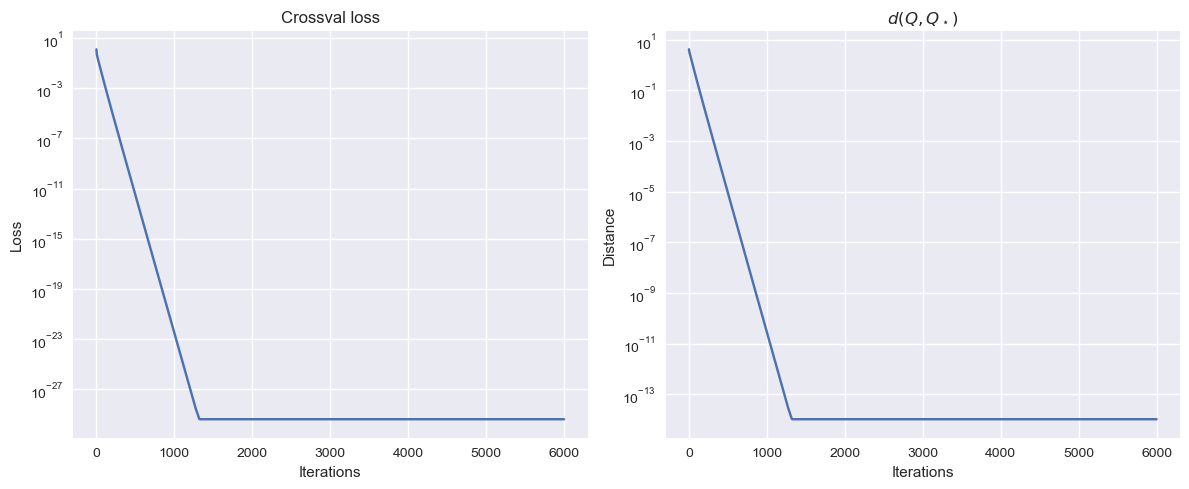

In [8]:
d_feature, n_samples = 5,5
inner_lr, outer_lr = 1, 0.4
n_potential_iterations = 6000

X, y, w_star = generate_std_basis_data(d_feature, n_samples)
w0 = np.ones((d_feature,))
Q0 = np.eye(d_feature)
#Q0 = np.random.randn(d_feature, d_feature)

Q_star = optimal_non_pd_potential_std_basis(w0, w_star, inner_lr)

Q = Q0.copy()
crossvals = np.zeros(n_potential_iterations)
Qs = np.zeros((n_potential_iterations, d_feature, d_feature))
for i in range(n_potential_iterations):
    crossvals[i] = crossval(w0, Q, inner_lr, X, y)
    Qs[i] = Q
    Q = potential_update(w0, Q, outer_lr, inner_lr, X, y, ignore_diag=False)
Q_dists = np.linalg.norm(Qs - Q_star, axis=(1, 2))

# Plotting results
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(crossvals)
plt.title("Crossval loss")
plt.yscale('log')
plt.xlabel("Iterations")
plt.ylabel("Loss")

plt.subplot(1, 2, 2)
plt.plot(Q_dists)
plt.title("$d(Q, Q_\star)$")
plt.yscale('log')
plt.xlabel("Iterations")
plt.ylabel("Distance")

plt.tight_layout()
plt.show()

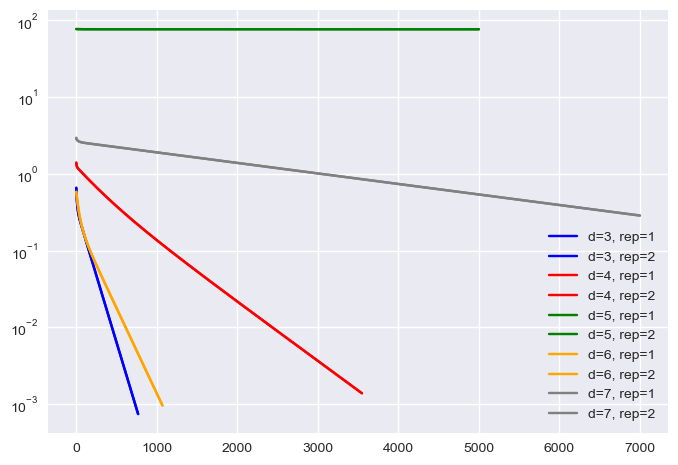

In [9]:
colors = ['blue', 'red', 'green', 'orange', 'gray', 'brown', 'purple']
eps = 1e-6
ignore_diag = False

for size in range(3, 8):
    d, n = size, size
    inner_lr, outer_lr = 1, 0.4
    n_potential_iterations = 1000 * size

    #print(f"size={size}, rep={rep}")
    X, y, w_star = generate_std_basis_data(d_feature, n_samples)
    w0 = np.ones((d_feature,))
    Q0 = np.eye(d_feature)
    Q_star = optimal_non_pd_potential_std_basis(w0, w_star, inner_lr)
    
    for rep in range(2):
        Q = Q0.copy()
        crossvals = []
        Qs = []

        for i in range(n_potential_iterations):
            Q = potential_update(w0, Q, outer_lr, inner_lr, X, y, ignore_diag=False)
            crossvals.append(crossval(w0, Q, inner_lr, X, y))
            Qs.append(Q.copy())
            if crossvals[-1] < eps:
                break

        crossvals = np.array(crossvals)
        Qs = np.array(Qs)
        #print(f"  final crossval: {crossvals[-1]}")
        
        j = size-3
        sp_diffs = np.array([stationarity_condition_Q(Q, X, w0, w_star, inner_lr) for Q in Qs])
        mean_abs_diffs = np.mean(np.abs(sp_diffs), axis=(1,2))
        plt.plot(mean_abs_diffs, color=f"{colors[j]}", label=f"d={size}, rep={rep+1}")
        
plt.yscale('log')
plt.legend()
plt.axhline(0, color="black")
plt.show()

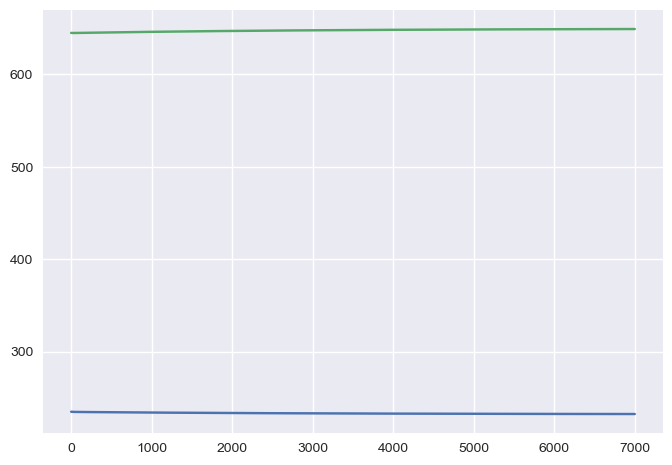

In [10]:
X_val = np.random.randn(n_samples, d_feature)

sp_diffs = np.array([stationarity_condition_Q(Q, X, w0, w_star, lr) for Q in Qs])
sp_diffs_val = np.array([stationarity_condition_Q(Q, X_val, w0, w_star, lr) for Q in Qs])

mean_abs_diffs = np.mean(np.abs(sp_diffs), axis=(1,2))
max_abs_diffs = np.max(np.abs(sp_diffs), axis=(1,2))
min_abs_diffs = np.min(np.abs(sp_diffs), axis=(1,2))

mean_abs_diffs_val = np.mean(np.abs(sp_diffs_val), axis=(1,2))
max_abs_diffs_val= np.max(np.abs(sp_diffs_val), axis=(1,2))
min_abs_diffs_val= np.min(np.abs(sp_diffs_val), axis=(1,2))

#plt.plot(max_abs_diffs)
plt.plot(mean_abs_diffs)
plt.plot(mean_abs_diffs_val)
#plt.plot(min_abs_diffs)
#plt.yscale('log')
plt.show()

## Graphs for single $w$

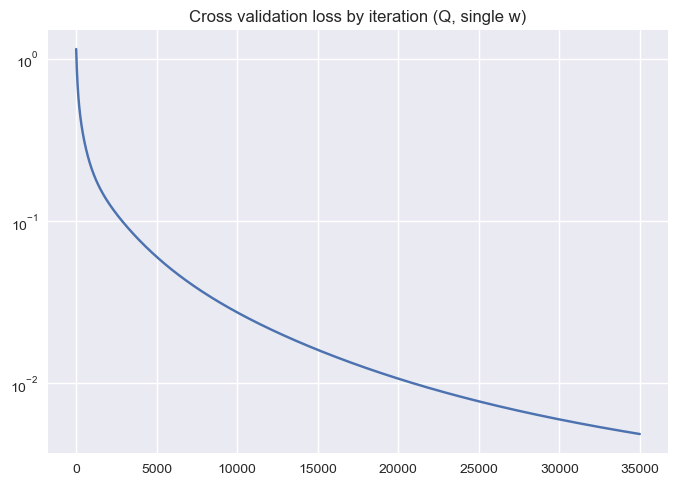

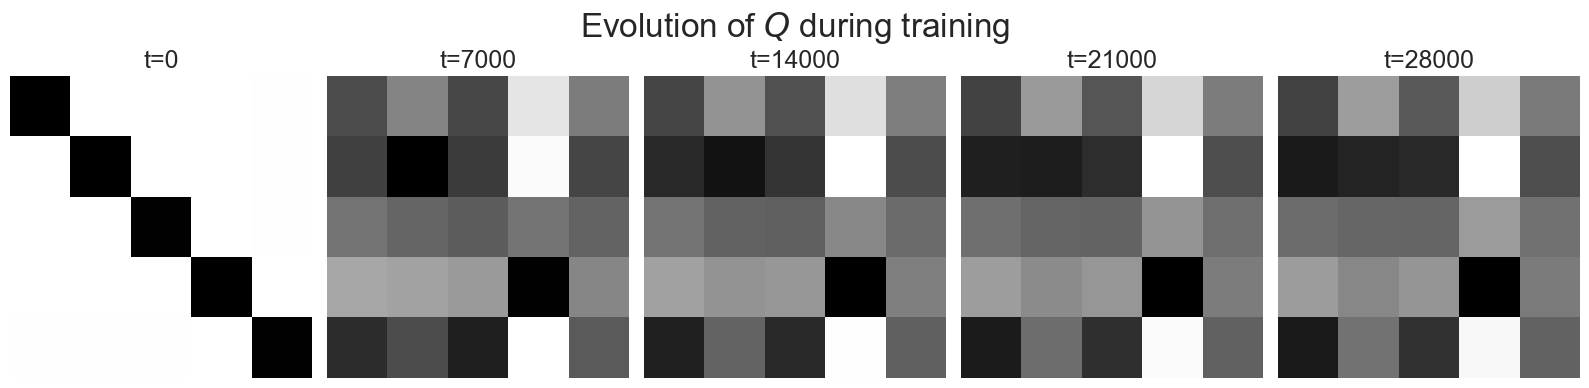

In [11]:
# Training setup
d,n = 5, 5
inner_lr, outer_lr = 0.1, 0.02
n_iters = 35000
w_cov = np.eye(d)
w0 = np.ones(d)
Q0 = np.eye(d)

# Training loop
crossvals, Qs, X, y, w_star = potential_training_loop(d, n, inner_lr, outer_lr, w0, Q0, n_iters, w_cov, seed=123)

# Plot crossvals
plt.plot(crossvals)
plt.title("Cross validation loss by iteration (Q, single w)")
plt.yscale('log')

# Plot images of Q iterates over time
n_images = 5
fig, axes = plt.subplots(1, n_images, figsize=(16, 4))
for j, i in enumerate(range(0, n_iters, n_iters//n_images)):
    ax = axes[j]
    im = ax.imshow(Qs[i])
    ax.axis('off')  # Turn off axes (including gridlines)
    ax.set_title(f't={i}', fontsize='18')
fig.suptitle('Evolution of $Q$ during training', fontsize='24')

plt.tight_layout()
plt.show()

### Stationary point condition: $x_j^\top Q x_i = z_j / (2 \eta z_i)$

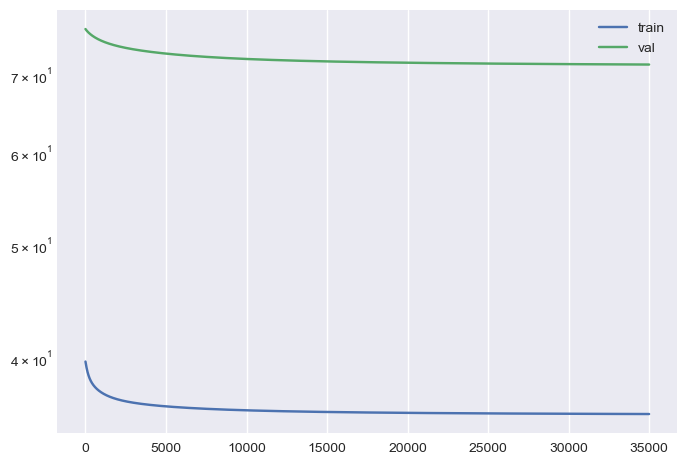

In [12]:
X_val = np.random.randn(n, d)

sp_diffs = np.array([stationarity_condition_Q(Q, X, w0, w_star, lr) for Q in Qs])
sp_diffs_val = np.array([stationarity_condition_Q(Q, X_val, w0, w_star, lr) for Q in Qs])

mean_abs_diffs = np.mean(np.abs(sp_diffs), axis=(1,2))
max_abs_diffs = np.max(np.abs(sp_diffs), axis=(1,2))
min_abs_diffs = np.min(np.abs(sp_diffs), axis=(1,2))

mean_abs_diffs_val = np.mean(np.abs(sp_diffs_val), axis=(1,2))
max_abs_diffs_val= np.max(np.abs(sp_diffs_val), axis=(1,2))
min_abs_diffs_val= np.min(np.abs(sp_diffs_val), axis=(1,2))

#plt.plot(max_abs_diffs)
plt.plot(mean_abs_diffs, label="train")
plt.plot(mean_abs_diffs_val, label="val")
plt.legend()
#plt.plot(min_abs_diffs)
plt.yscale('log')
plt.show()


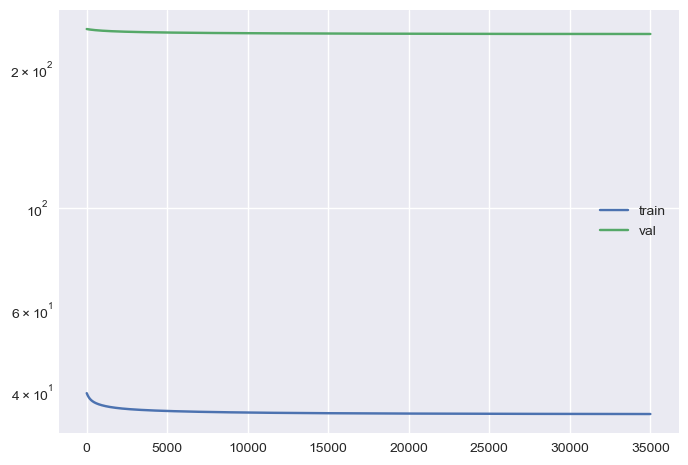

In [13]:
X_val = np.random.randn(n, d)
y_val = X_val @ w_star

sp_diffs = np.array([stationarity_condition_Q(Q, X, w0, w_star, lr) for Q in Qs])
sp_diffs_val = np.array([stationarity_condition_Q(Q, X_val, w0, w_star, lr) for Q in Qs])

mean_abs_diffs = np.mean(np.abs(sp_diffs), axis=(1,2))
max_abs_diffs = np.max(np.abs(sp_diffs), axis=(1,2))
min_abs_diffs = np.min(np.abs(sp_diffs), axis=(1,2))

mean_abs_diffs_val = np.mean(np.abs(sp_diffs_val), axis=(1,2))
max_abs_diffs_val= np.max(np.abs(sp_diffs_val), axis=(1,2))
min_abs_diffs_val= np.min(np.abs(sp_diffs_val), axis=(1,2))

#plt.plot(max_abs_diffs)
plt.plot(mean_abs_diffs, label="train")
plt.plot(mean_abs_diffs_val, label="val")
plt.legend()
#plt.plot(min_abs_diffs)
plt.yscale('log')
plt.show()

### Compare to a single step of gradient descent

In [14]:
Q_final = Qs[-1]
lr = inner_lr

trained_md_crossvals = []
gd_crossvals = []
X_vals = []
for i in np.arange(1500):
    X_val = np.random.randn(n, d)
    y_val = X_val @ w_star
    trained_md_crossvals.append(crossval(w0, Q_final, lr, X_val, y_val))
    gd_crossvals.append(crossval(w0, np.eye(d), lr, X_val, y_val))
    X_vals.append(X_val)


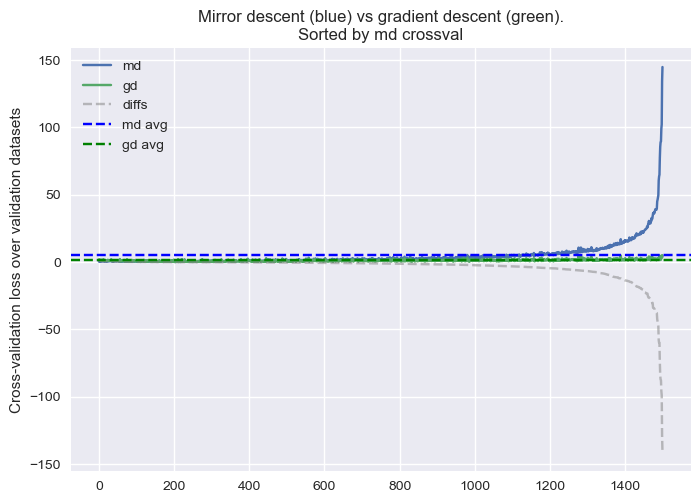

In [15]:
md_gd_crossvals = np.array([trained_md_crossvals, gd_crossvals])
sorted_indices = np.argsort(md_gd_crossvals[0])                        # sort by value of md crossval
sorted_indices = np.argsort(md_gd_crossvals[0] - md_gd_crossvals[1])   # sort by difference between crossvals
md_gd_crossvals = md_gd_crossvals[:, sorted_indices]
X_vals = np.array(X_vals)[sorted_indices]

plt.plot(md_gd_crossvals[0], label="md")
plt.plot(md_gd_crossvals[1], label="gd")
plt.plot(md_gd_crossvals[1] - md_gd_crossvals[0], alpha=0.5, linestyle='--', color='gray', label="diffs")
plt.axhline(y=np.mean(md_gd_crossvals[0]), label="md avg", color='blue', linestyle='--')
plt.axhline(y=np.mean(md_gd_crossvals[1]), label="gd avg", color='green', linestyle='--')
plt.ylabel("Cross-validation loss over validation datasets")
plt.title("Mirror descent (blue) vs gradient descent (green).\nSorted by md crossval")
plt.legend()
plt.show()

**Explanation of next cell: Investigating `X_val` statistics across runs.**

`-----------------There's stuff here that I'd like to follow up on-------------------`

Typically, what I see above is that mirror descent does better (yay!).

Sometimes it seems to do worse, consistently -- not sure if this was an error in the code, a bad $Q$, or what.

And sometimes it seems to do better most of the time, maybe 90%, but then do worse sometimes. I (i.e. Claude) wrote the code below to investigate whether, in these cases, the `X_val` data that md performs better on is systematically different from the data that gd performs better on.

I did a 3-minute training run for $Q$ to make sure I was working with something good, and then had a consistently good gap between md and gd over many iterations -- they never swapped places. So maybe it was an undertraining issue the whole time?

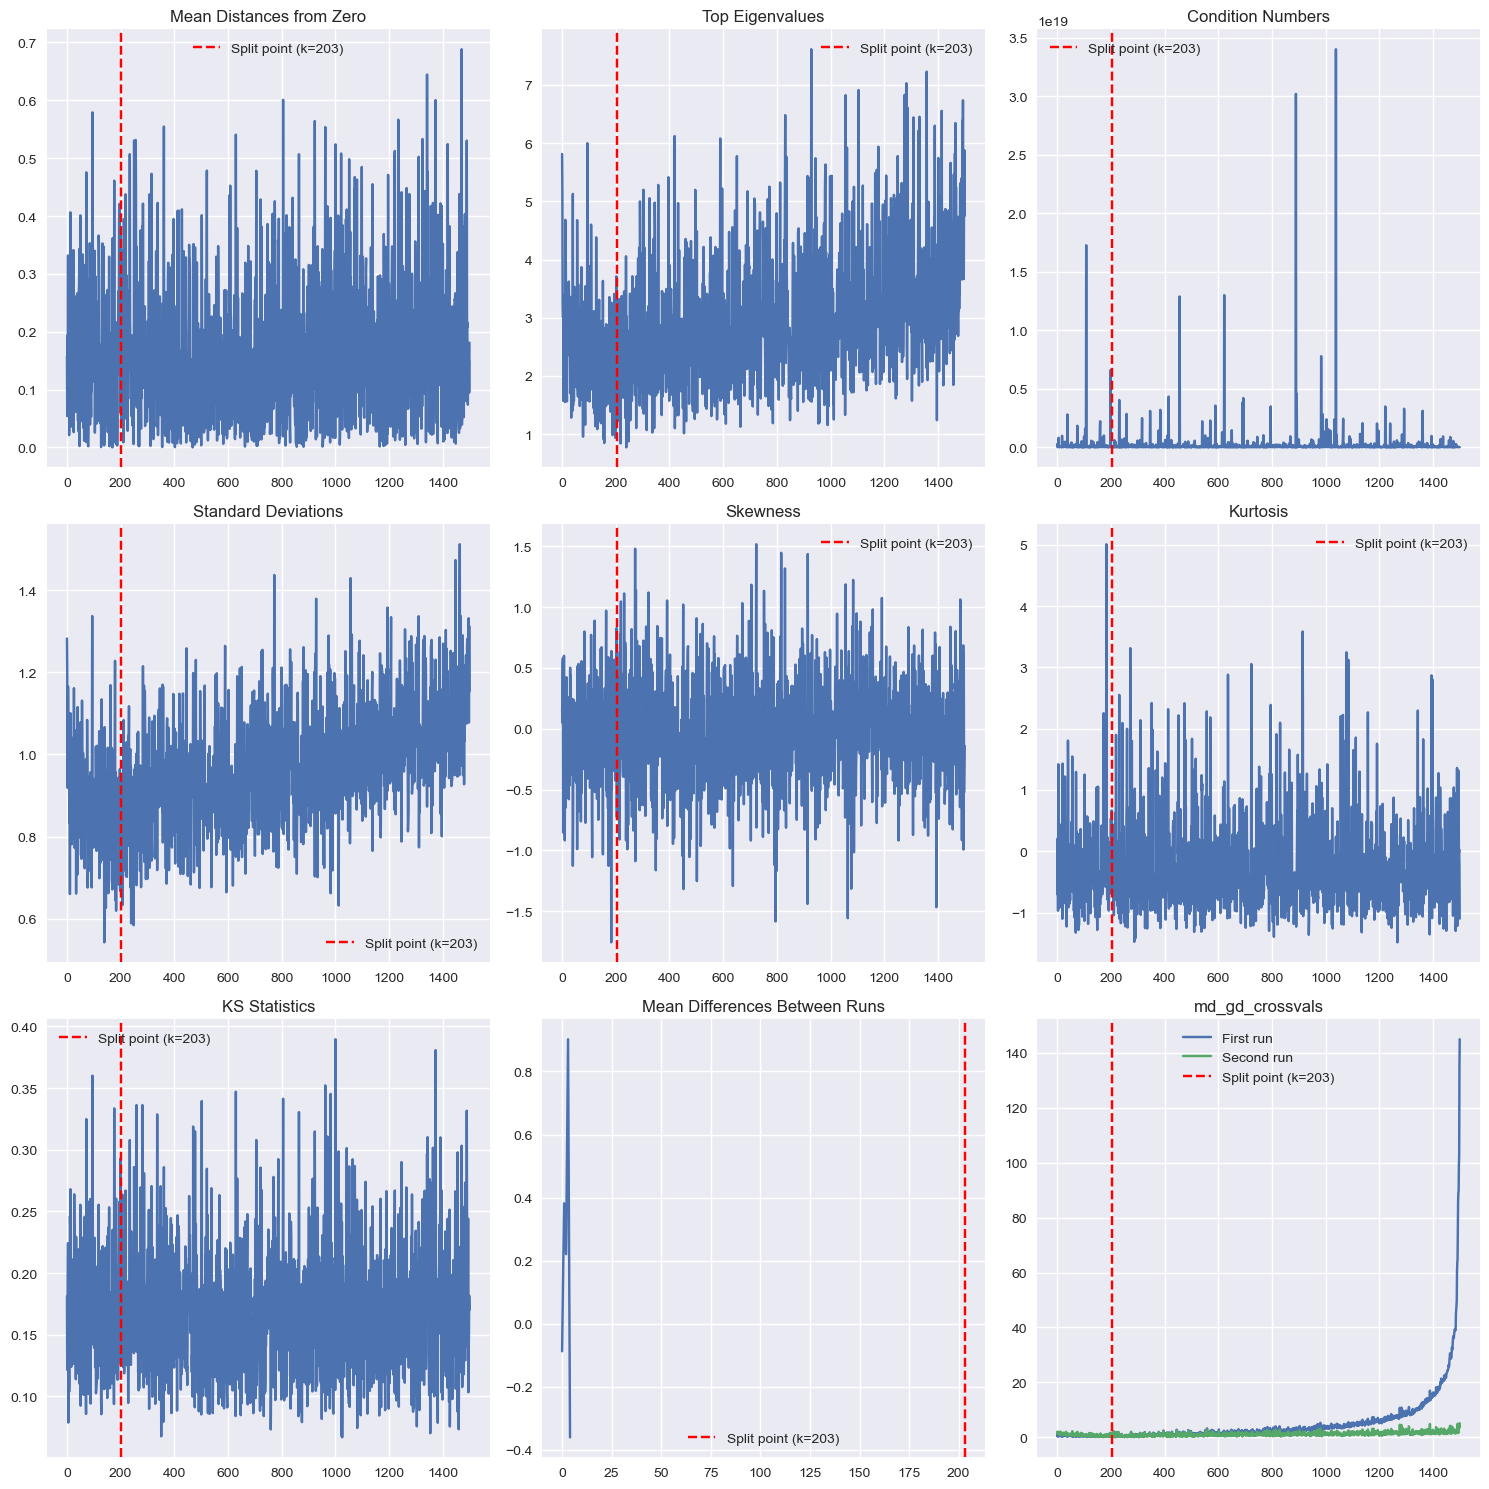

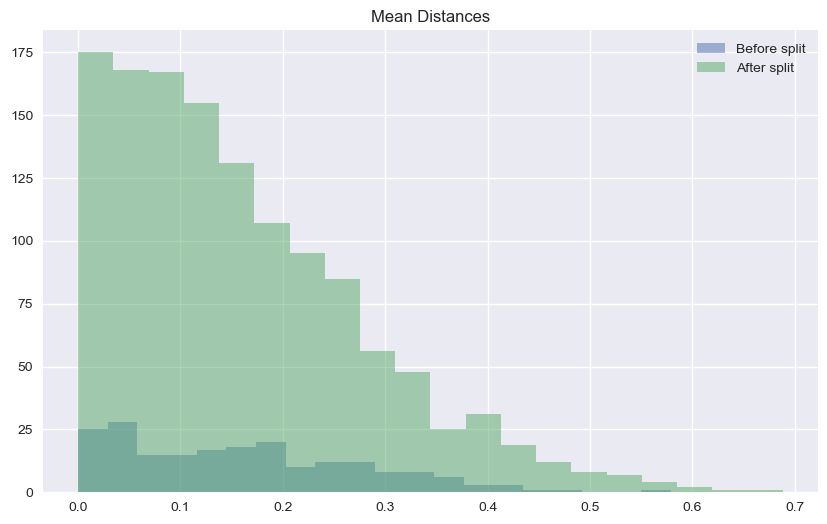

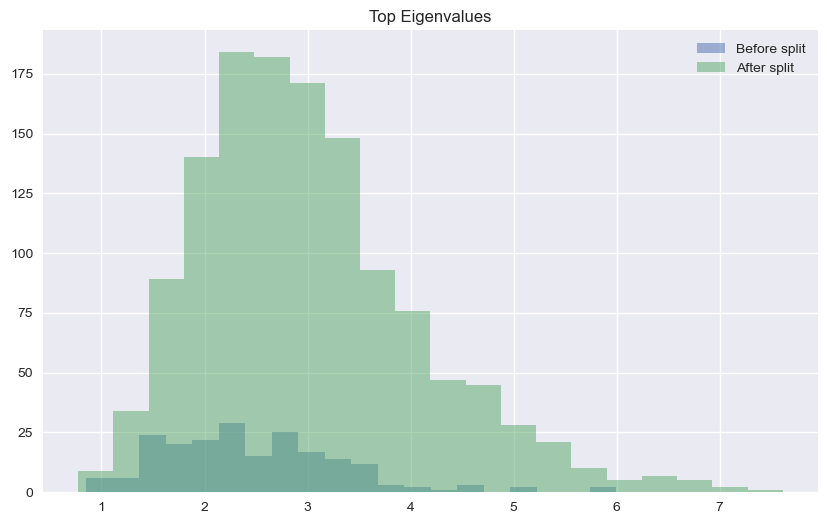

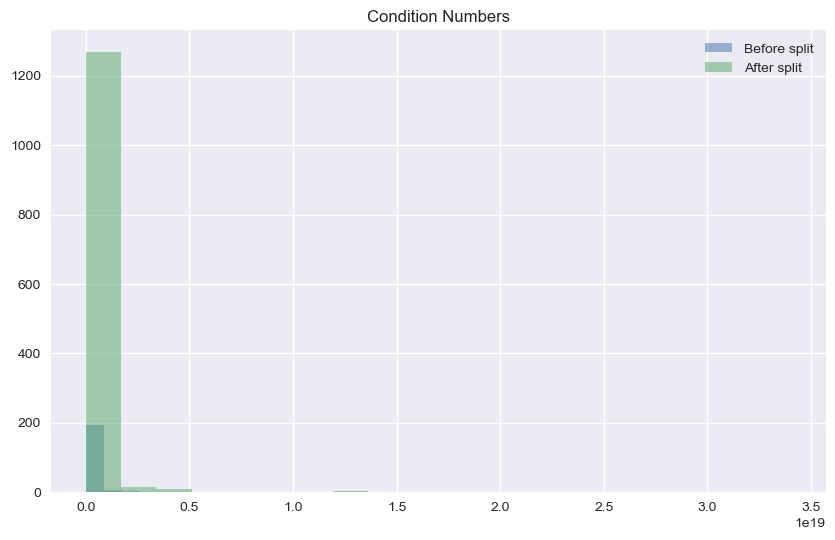

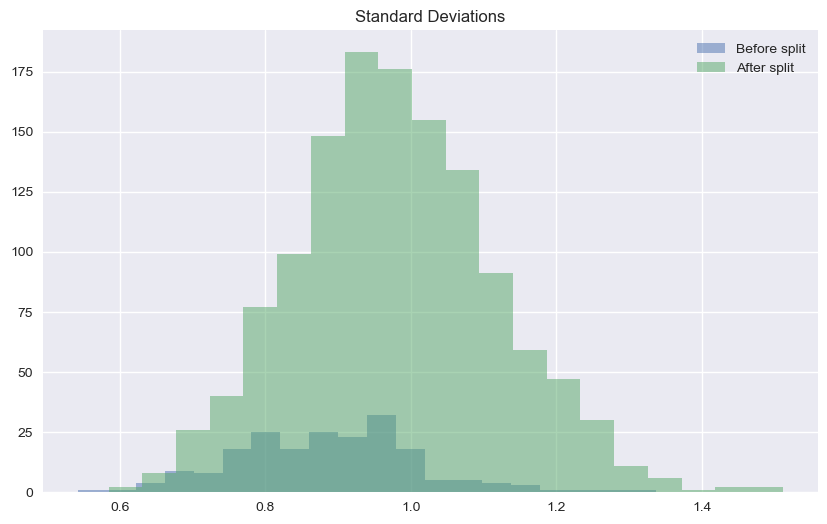

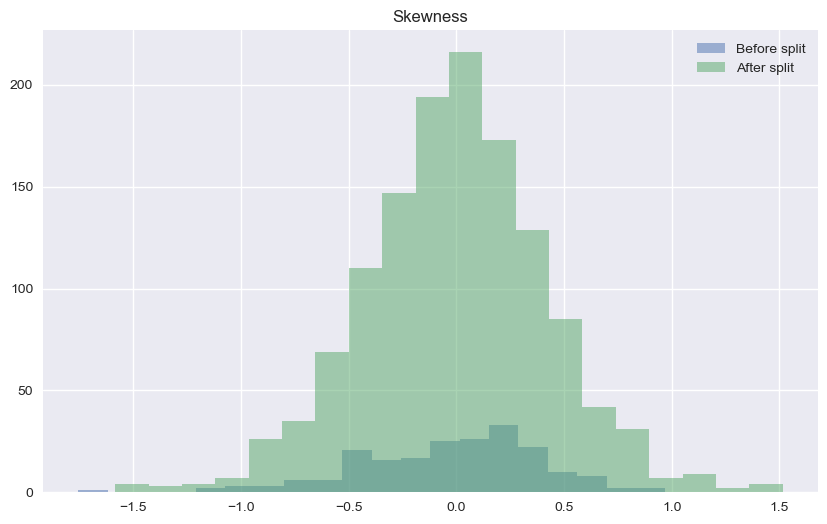

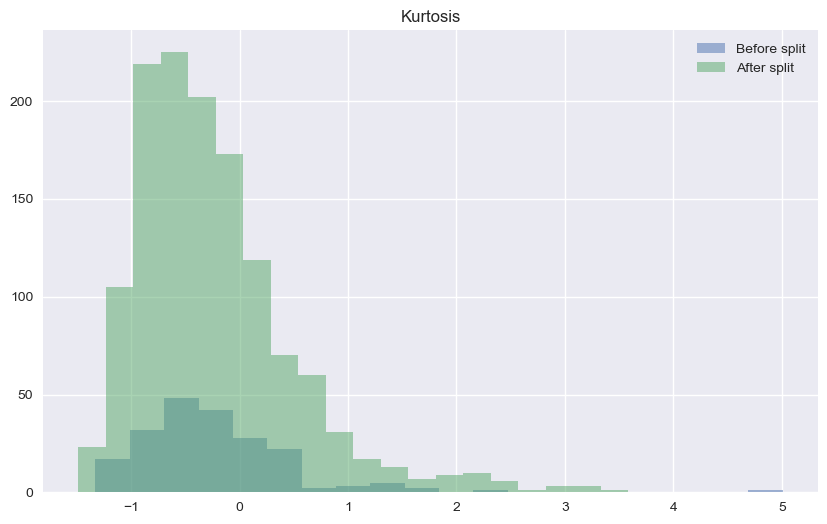

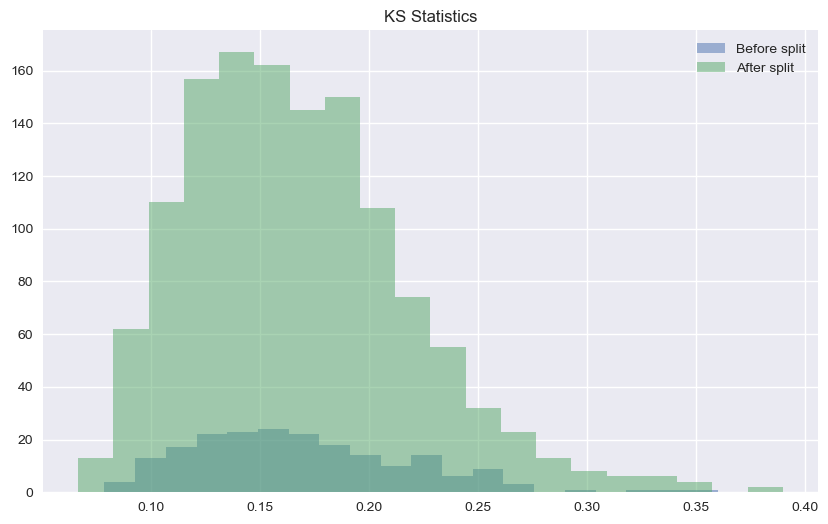

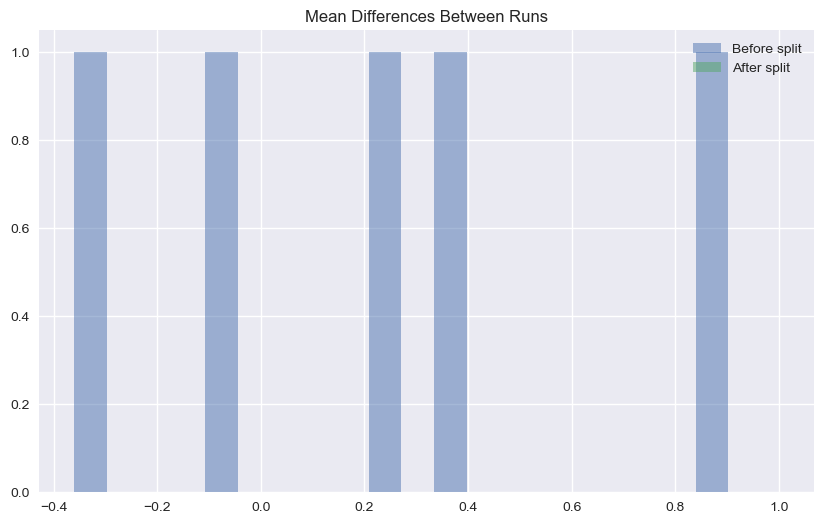


Mean Distances:
Before split: mean = 0.1602, std = 0.1168
After split: mean = 0.1607, std = 0.1210

Top Eigenvalues:
Before split: mean = 2.4787, std = 0.8858
After split: mean = 3.0060, std = 1.0697

Condition Numbers:
Before split: mean = 279618272150515200.0000, std = 1325856877067239680.0000
After split: mean = 236977264450044992.0000, std = 1438273211303396352.0000

Standard Deviations:
Before split: mean = 0.8864, std = 0.1269
After split: mean = 0.9785, std = 0.1370

Skewness:
Before split: mean = -0.0326, std = 0.4214
After split: mean = -0.0051, std = 0.4245

Kurtosis:
Before split: mean = -0.2352, std = 0.7148
After split: mean = -0.2375, std = 0.7286

KS Statistics:
Before split: mean = 0.1692, std = 0.0500
After split: mean = 0.1672, std = 0.0506

Mean Differences Between Runs:
Before split: mean = 0.2116, std = 0.4295
After split: mean = nan, std = nan

Split point (k) where md_gd_crossvals[0,k] >= md_gd_crossvals[1,k]: 203


/Users/Alex/miniconda3/envs/alexenv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/Alex/miniconda3/envs/alexenv/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/Alex/miniconda3/envs/alexenv/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/Alex/miniconda3/envs/alexenv/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/Alex/miniconda3/envs/alexenv/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [16]:
from scipy import stats

# Find the split point where md_gd_crossvals[0,k] >= md_gd_crossvals[1,k]
split_point = np.argmax(md_gd_crossvals[0] >= md_gd_crossvals[1])

# Calculate various statistics
means = np.mean(X_vals, axis=(1, 2))
mean_distances = np.abs(means)
cov_matrices = np.array([np.cov(X.T) for X in X_vals])
top_eigenvalues = np.array([np.linalg.eigvals(cov).max() for cov in cov_matrices])
condition_numbers = np.array([np.linalg.cond(cov) for cov in cov_matrices])
std_devs = np.std(X_vals, axis=(1, 2))
skewness = np.mean(((X_vals - np.mean(X_vals, axis=(1, 2), keepdims=True)) / 
                    np.std(X_vals, axis=(1, 2), keepdims=True))**3, axis=(1, 2))
kurtosis = np.mean(((X_vals - np.mean(X_vals, axis=(1, 2), keepdims=True)) / 
                    np.std(X_vals, axis=(1, 2), keepdims=True))**4, axis=(1, 2)) - 3
ks_stats = np.array([stats.kstest(X.flatten(), 'norm').statistic for X in X_vals])

# Calculate the difference between the two runs
run_differences = X_vals[1] - X_vals[0]
diff_means = np.mean(run_differences, axis=1)

# Plotting function for line plots
def plot_metric(ax, metric, title):
    ax.plot(metric)
    ax.set_title(title)
    ax.axvline(x=split_point, color='r', linestyle='--', label=f'Split point (k={split_point})')
    ax.legend()

# Create line plots
fig, axs = plt.subplots(3, 3, figsize=(15, 15))
plot_metric(axs[0, 0], mean_distances, 'Mean Distances from Zero')
plot_metric(axs[0, 1], top_eigenvalues, 'Top Eigenvalues')
plot_metric(axs[0, 2], condition_numbers, 'Condition Numbers')
plot_metric(axs[1, 0], std_devs, 'Standard Deviations')
plot_metric(axs[1, 1], skewness, 'Skewness')
plot_metric(axs[1, 2], kurtosis, 'Kurtosis')
plot_metric(axs[2, 0], ks_stats, 'KS Statistics')
plot_metric(axs[2, 1], diff_means, 'Mean Differences Between Runs')

# Plot md_gd_crossvals
axs[2, 2].plot(md_gd_crossvals[0], label='First run')
axs[2, 2].plot(md_gd_crossvals[1], label='Second run')
axs[2, 2].axvline(x=split_point, color='r', linestyle='--', label=f'Split point (k={split_point})')
axs[2, 2].set_title('md_gd_crossvals')
axs[2, 2].legend()

plt.tight_layout()
plt.show()

# Function to plot overlapping histograms
def plot_overlapping_histogram(data, title):
    plt.figure(figsize=(10, 6))
    plt.hist(data[:split_point], bins=20, alpha=0.5, label='Before split')
    plt.hist(data[split_point:], bins=20, alpha=0.5, label='After split')
    plt.title(title)
    plt.legend()
    plt.show()

# # Plot overlapping histograms for each metric
# metrics = [mean_distances, top_eigenvalues, condition_numbers, std_devs, skewness, kurtosis, ks_stats, diff_means]
# metric_names = ['Mean Distances', 'Top Eigenvalues', 'Condition Numbers', 'Standard Deviations', 
#                 'Skewness', 'Kurtosis', 'KS Statistics', 'Mean Differences Between Runs']

# for metric, name in zip(metrics, metric_names):
#     plot_overlapping_histogram(metric, name)

# # Print summary statistics for before and after split point
# def print_summary(metric, name):
#     print(f"\n{name}:")
#     print(f"Before split: mean = {np.mean(metric[:split_point]):.4f}, std = {np.std(metric[:split_point]):.4f}")
#     print(f"After split: mean = {np.mean(metric[split_point:]):.4f}, std = {np.std(metric[split_point:]):.4f}")

# for metric, name in zip(metrics, metric_names):
#     print_summary(metric, name)

# Print the split point
print(f"\nSplit point (k) where md_gd_crossvals[0,k] >= md_gd_crossvals[1,k]: {split_point}")

## Graphs for mixed $w$ / recovering covariance

Questions:
* Are there consistent, visible patterns in $Q$?
* What properties are preseved between multiple runs with different data?
* How does $\Sigma_w$ itself perform as a mirror map?

### Low-rank $\Sigma_w$

### Poorly-conditioned $\Sigma_w$

# $UU^\top$ parameterization

## Basic training loop

## Graphs for single $w$

## Graphs for mixed $w$ / recovering covariance